# **Importing Libraries**

 We import all the libraries necessary for our data analysis, preprocessing, model training, and model evaluation.

In [1]:
# Import necessary libraries
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from typing import Union, List
import joblib
import re
import os

# **Loading the Dataset**

Let's load the dataset directly from the file directory using pandas read_csv function.

In [2]:
data = pd.read_csv('data/WEOOct2020all.csv')
data.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,255.29","1,270.22","1,319.90","1,253.91","1,304.06","1,363.06","1,424.40","1,481.50","1,540.94",2019.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,2.647,1.189,3.912,-5,4,4.524,4.5,4.009,4.012,2019.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,285.46","1,327.69","1,469.60","1,465.92","1,597.74","1,741.83","1,893.02","2,047.67","2,215.01",2019.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,18.91,18.401,18.876,19.006,19.692,20.829,22.022,23.169,24.372,2019.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,74.712,77.416,81.88,78.884,83.852,89.205,94.908,100.6,106.685,2019.0


# **Country Continent Categorization**

Let's proceed by loading a dataset that categorizes countries by continent
Data was obtained from [link text](https://statisticstimes.com/geography/countries-by-continents.php)

In [30]:
df_country_classification = pd.read_csv('data/countries_by_continent.csv')

# Create a dictionary mapping each unique Continent to a unique identifier starting from 1
continent_to_id = {continent: i+1 for i, continent in enumerate(df_country_classification['Continent'].unique())}

# Create a new column 'Continent ID' which is the unique identifier for each Continent
# df_country_classification['Continent_ID'] = df_country_classification['Continent'].apply(lambda x: continent_to_id[x])

df_country_classification['Continent_ID'] = pd.factorize(df_country_classification['Continent'])[0]

# Display first few rows
df_country_classification.head()


,No,Country or Area,ISO-alpha3 Code,M49 Code,Region 1,Region 2,Continent,Continent_ID
0,1,Afghanistan,AFG,4,Southern Asia,NaN,Asia,0
1,2,Åland Islands,ALA,248,Northern Europe,NaN,Europe,1
2,3,Albania,ALB,8,Southern Europe,NaN,Europe,1
3,4,Algeria,DZA,12,Northern Africa,NaN,Africa,2
4,5,American Samoa,ASM,16,Polynesia,NaN,Oceania,3


In [4]:
# If 'Continent' exists in the 'data' DataFrame, drop it
if 'Continent' in data.columns:
    data.drop(columns='Continent', inplace=True)

# Merge the main data with the countries and continents data
df_merged = data.merge(df_country_classification[['ISO-alpha3 Code', 'Continent', 'Continent_ID']],
                         left_on='ISO',
                         right_on='ISO-alpha3 Code',
                         how='left')

# Remove duplicate 'ISO-alpha3 Code' column
df_merged.drop(columns='ISO-alpha3 Code', inplace=True)

# Reorder columns to have 'Continent' and 'Continent ID' right next to 'ISO'
column_list = df_merged.columns.tolist()
iso_index = column_list.index('ISO')

if 'Continent' in column_list:
    column_list.remove('Continent')
    column_list.insert(iso_index + 1, 'Continent')

if 'Continent_ID' in column_list:
    column_list.remove('Continent_ID')
    column_list.insert(iso_index + 2, 'Continent_ID')

# Reorder the dataframe
data = df_merged[column_list]

data.head()


,WEO Country Code,ISO,Continent,Continent_ID,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,Estimates Start After
0,512,AFG,Asia,1.0,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,...,"1,255.29","1,270.22","1,319.90","1,253.91","1,304.06","1,363.06","1,424.40","1,481.50","1,540.94",2019.0
1,512,AFG,Asia,1.0,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,...,2.647,1.189,3.912,-5,4,4.524,4.5,4.009,4.012,2019.0
2,512,AFG,Asia,1.0,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,...,"1,285.46","1,327.69","1,469.60","1,465.92","1,597.74","1,741.83","1,893.02","2,047.67","2,215.01",2019.0
3,512,AFG,Asia,1.0,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,...,18.91,18.401,18.876,19.006,19.692,20.829,22.022,23.169,24.372,2019.0
4,512,AFG,Asia,1.0,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,...,74.712,77.416,81.88,78.884,83.852,89.205,94.908,100.6,106.685,2019.0


# **Question 1**

Find the top 10 countries that grew "Gross domestic product per capita" the most over the last decade.

In [5]:
# Filter data for the 'NGDPDPC' WEO subject code
gdp_per_capita_data = data[data['WEO Subject Code'] == 'NGDPDPC'].copy()

# Convert years columns to numeric, errors='coerce' will turn non-numeric values into NaN
for year in ['2010', '2020']:
    gdp_per_capita_data.loc[:, year] = pd.to_numeric(gdp_per_capita_data[year].str.replace(',', ''), errors='coerce')

# Calculate the growth rate from 2010 to 2020
gdp_per_capita_data['Growth'] = (gdp_per_capita_data['2020'] - gdp_per_capita_data['2010']) / gdp_per_capita_data['2010']

# Sort by growth rate and get the top 10
top_10_gdp_growth = gdp_per_capita_data.sort_values(by='Growth', ascending=False).head(10)

top_10_gdp_growth[['Country', '2010', '2020', 'Growth']]


,Country,2010,2020,Growth
2529,Ethiopia,324.285,974.088,2.003802
594,Bangladesh,762.804,1887.97,1.475039
1584,China,4499.79,10582.1,1.351688
3159,Guyana,3837.3,8648.55,1.253811
8559,Vietnam,1628.52,3497.51,1.147662
4194,Lao P.D.R.,1200.87,2567.01,1.137625
1314,Cambodia,781.912,1571.92,1.010354
3924,Kenya,1036.26,2075.22,1.002606
5454,Nepal,592.369,1115.56,0.883218
5409,Nauru,4748.08,8866.87,0.867464


# **Question 2**

Draw OECD countries' "Population" growth over the last decade.

In [6]:
# Define the list of OECD countries
oecd_countries = [
    "Australia", "Austria", "Belgium", "Canada", "Chile", "Colombia",
    "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany",
    "Greece", "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Japan",
    "Korea", "Latvia", "Lithuania", "Luxembourg", "Mexico", "Netherlands",
    "New Zealand", "Norway", "Poland", "Portugal", "Slovak Republic",
    "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey", "United Kingdom",
    "United States"
]

# Filter the data for OECD countries
data_oecd = data[data['Country'].isin(oecd_countries)]

# Further filter the data for Population
data_oecd_population = data_oecd[data_oecd['Subject Descriptor'] == 'Population']

# Filter for the last decade assuming that the last decade is between 2010 and 2020
data_oecd_population_last_decade = data_oecd_population.loc[:, ['Country', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']]

# Check the resulting DataFrame
data_oecd_population_last_decade.head()


,Country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
387,Australia,22.172,22.522,22.928,23.298,23.64,23.985,24.39,24.773,25.172,25.522,25.724
432,Austria,8.361,8.389,8.426,8.477,8.544,8.63,8.74,8.815,8.885,8.859,8.901
747,Belgium,10.84,11.001,11.076,11.138,11.181,11.237,11.311,11.352,11.399,11.456,11.49
1422,Canada,33.958,34.298,34.665,35.034,35.392,35.678,36.052,36.492,36.994,37.527,38.029
1557,Chile,17.064,17.254,17.443,17.612,17.788,17.971,18.167,18.419,18.751,19.107,19.458


In [7]:
# Convert population data to numerical values
for year in range(2010, 2020):
    data_oecd_population_last_decade[str(year)] = data_oecd_population_last_decade[str(year)].str.replace(',', '').astype(float)

# Transpose the data to have years as rows and countries as columns
data_oecd_population_last_decade_transposed = data_oecd_population_last_decade.set_index('Country').transpose()

# Check the resulting DataFrame
data_oecd_population_last_decade_transposed.head()


Country,Australia,Austria,Belgium,Canada,Chile,Colombia,Czech Republic,Denmark,Estonia,Finland,...,Poland,Portugal,Slovak Republic,Slovenia,Spain,Sweden,Switzerland,Turkey,United Kingdom,United States
2010,22.172,8.361,10.84,33.958,17.064,45.51,10.462,5.535,1.331,5.351,...,38.023,10.573,5.39,2.047,46.562,9.416,7.786,73.723,62.76,309.732
2011,22.522,8.389,11.001,34.298,17.254,46.045,10.487,5.561,1.327,5.375,...,38.063,10.558,5.392,2.05,46.736,9.483,7.87,74.724,63.285,311.918
2012,22.928,8.426,11.076,34.665,17.443,46.582,10.505,5.581,1.323,5.401,...,38.064,10.515,5.404,2.055,46.766,9.556,7.955,75.627,63.705,314.121
2013,23.298,8.477,11.138,35.034,17.612,47.121,10.516,5.603,1.318,5.427,...,38.063,10.457,5.411,2.059,46.593,9.645,8.039,76.668,64.106,316.266
2014,23.64,8.544,11.181,35.392,17.788,47.662,10.512,5.627,1.315,5.451,...,38.018,10.401,5.416,2.061,46.455,9.747,8.14,77.696,64.597,318.535


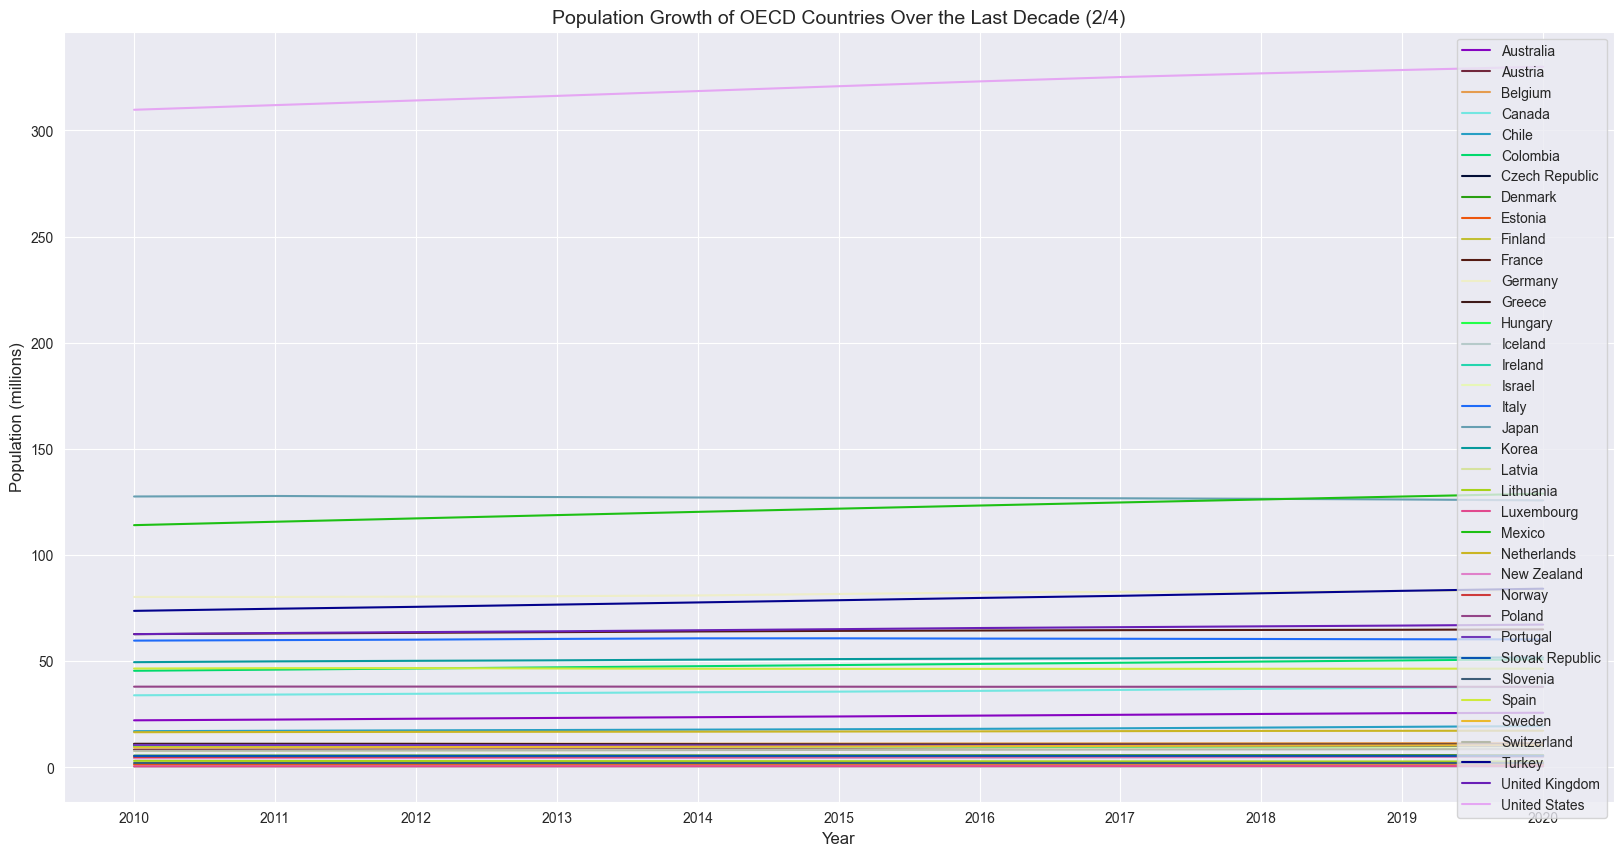

In [8]:

# Let's generate 40 random colors directly in a list comprehension
colors: List[str] = ['#%02x%02x%02x' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(40)]
# Define the size of the figure
plt.figure(figsize=(20, 10))

for i, country in enumerate(data_oecd_population_last_decade_transposed.columns):
    plt.plot(data_oecd_population_last_decade_transposed.index, data_oecd_population_last_decade_transposed[country], color=colors[i % len(colors)], label=country)

# Set plot title and labels
plt.title('Population Growth of OECD Countries Over the Last Decade (2/4)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Population (millions)', fontsize=12)

# Add legend
plt.legend()

# Show the plot
plt.show()


# **Question 3**

Save the GDP growth figures in separate charts and save them as PNG files

In addressing the question, I am operating under a couple of assumptions:

1. Your query is a continuation of the previous question, meaning it builds upon the context and information provided earlier.
2. The data required for this analysis pertains to the last decade, specifically from the years 2010 to 2020.

In [9]:
# Filter the data for GDP growth
data_oecd_gdp_growth = data_oecd[data_oecd['WEO Subject Code'] == 'NGDP']

# Filter for the last decade assuming that the last decade is between 2010 and 2020
data_oecd_gdp_growth_decade = data_oecd_gdp_growth.loc[:, ['Country', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']]

# Convert GDP growth data to numerical values
for year in range(2010, 2021):
    data_oecd_gdp_growth_decade[str(year)] = data_oecd_gdp_growth_decade[str(year)].replace(',', '', regex=True).astype(float)

print("GDP growth charts will be successfully saved in less than five minutes")

# Create a directory for the images if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Generate and save plots for each country
for country in data_oecd_gdp_growth_decade['Country'].unique():
    # Filter data for the specific country and drop rows with missing values
    country_data = data_oecd_gdp_growth_decade[data_oecd_gdp_growth_decade['Country'] == country]
    country_data = country_data.loc[:, '2010':'2020'].dropna(axis=1)

    # Only generate a plot if there's data for the country
    if not country_data.empty:
        # Create a new figure
        plt.figure(figsize=(10,6))

        # Generate the line plot
        plt.plot(country_data.columns, country_data.values[0], marker='o')

        # Add title and labels
        plt.title(f'GDP Growth for {country} (2010-2020)', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('GDP Growth (Percent change)', fontsize=14)

        # Save the figure as a PNG file
        plt.savefig(f'images/gdp_growth_{country}.png', bbox_inches='tight')

        # Close the figure to free up memory
        plt.close()


GDP growth charts will be successfully saved in less than five minutes


# **Question 4**

Create 5 clusters out of the countries using GDP and "Volume of exports of goods".
a. Draw the charts (x-axis - GDP, y - volume).
b. Add labels for the top 5 countries according to the GDP on the dots representing countries in each cluster.

In [10]:
# Filter the data for the needed indicators
gdp_data = data[data['WEO Subject Code'] == 'NGDPD']
exports_data = data[data['WEO Subject Code'] == 'TMG_RPCH']

# Extract the most recent year data
most_recent_year = max([int(column) for column in data.columns if column.isdigit()])
gdp_most_recent = gdp_data[str(most_recent_year)]
exports_most_recent = exports_data[str(most_recent_year)]

# Create a new DataFrame with the relevant information
cluster_data = pd.DataFrame({
    'Country': gdp_data['Country'],
    'GDP': gdp_most_recent,
    'Exports': exports_most_recent
})

# Remove rows with missing data
cluster_data = cluster_data.dropna()

# Convert GDP and Exports to numeric
cluster_data['GDP'] = cluster_data['GDP'].str.replace(',', '').astype(float)
cluster_data['Exports'] = cluster_data['Exports'].str.replace(',', '').astype(float)

cluster_data.head()


,Country,GDP,Exports


In [11]:
# Check the number of non-null entries for each indicator
gdp_non_null = gdp_data[str(most_recent_year)].notna().sum()
exports_non_null = exports_data[str(most_recent_year)].notna().sum()

gdp_non_null, exports_non_null


(191, 174)

In [12]:
# Extract relevant columns
gdp_data_filtered = gdp_data[['Country', str(most_recent_year)]]
exports_data_filtered = exports_data[['Country', str(most_recent_year)]]

# Rename columns for clarity
gdp_data_filtered.columns = ['Country', 'GDP']
exports_data_filtered.columns = ['Country', 'Exports']

# Merge the two datasets
merged_data = pd.merge(gdp_data_filtered, exports_data_filtered, on='Country', how='inner')

# Clean data - remove rows with missing values and convert to numeric
merged_data['GDP'] = merged_data['GDP'].str.replace(',', '').astype(float)
merged_data['Exports'] = merged_data['Exports'].str.replace(',', '').astype(float)
merged_data = merged_data.dropna()

merged_data.head()


,Country,GDP,Exports
0,Afghanistan,24.372,1.628
1,Albania,20.052,4.711
2,Algeria,174.761,1.759
3,Angola,91.453,3.993
4,Antigua and Barbuda,2.037,2.039


In [13]:
# Normalize the data before clustering
merged_data['GDP_norm'] = (merged_data['GDP'] - merged_data['GDP'].min()) / (merged_data['GDP'].max() - merged_data['GDP'].min())
merged_data['Exports_norm'] = (merged_data['Exports'] - merged_data['Exports'].min()) / (merged_data['Exports'].max() - merged_data['Exports'].min())

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, n_init=10, random_state=0)
merged_data['cluster'] = kmeans.fit_predict(merged_data[['GDP_norm', 'Exports_norm']])

# Identify top 5 countries by GDP in each cluster
top_countries = merged_data.groupby('cluster')['GDP'].nlargest(5)
top_countries_idx = top_countries.index.get_level_values(1)

# Label for top countries
merged_data['label'] = np.where(merged_data.index.isin(top_countries_idx), merged_data['Country'], '')

merged_data.head()


,Country,GDP,Exports,GDP_norm,Exports_norm,cluster,label
0,Afghanistan,24.372,1.628,0.000935,0.034210,0,
1,Albania,20.052,4.711,0.000768,0.059570,0,
2,Algeria,174.761,1.759,0.006768,0.035288,0,
3,Angola,91.453,3.993,0.003537,0.053664,0,
4,Antigua and Barbuda,2.037,2.039,0.000069,0.037591,0,


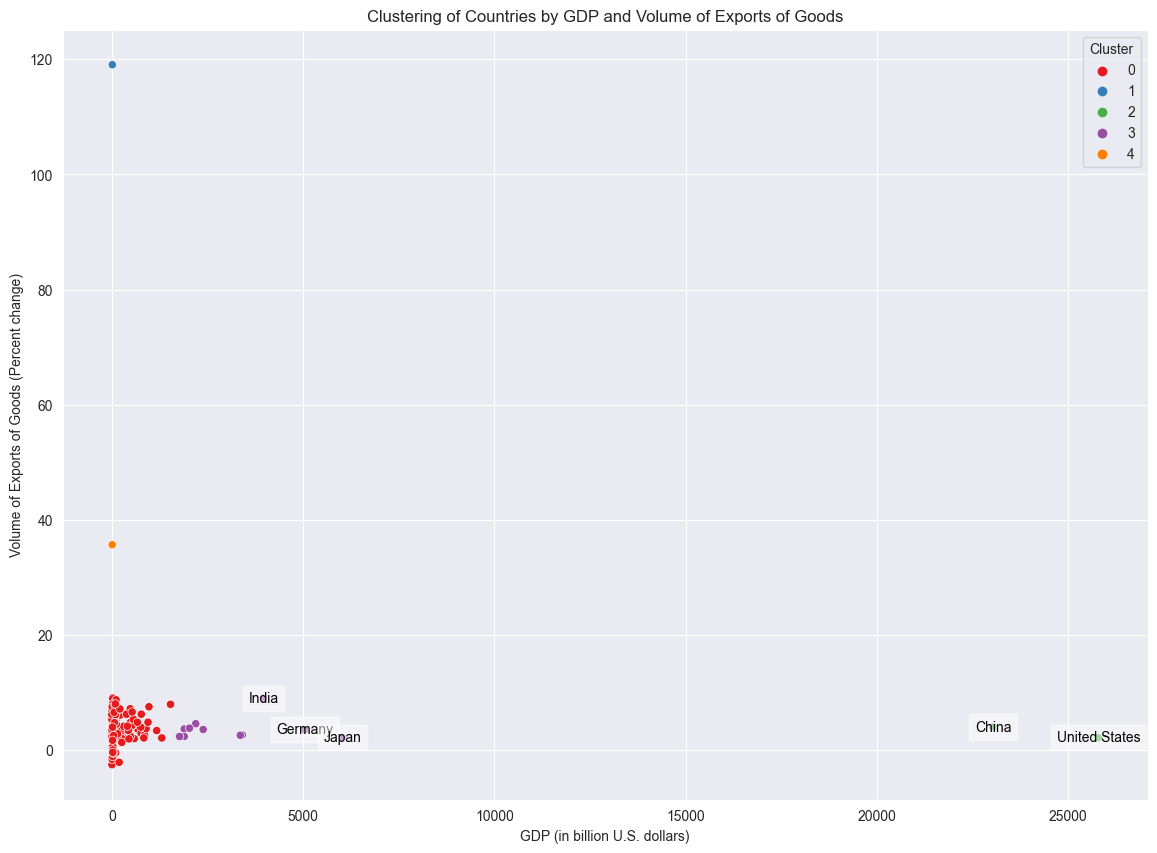

In [14]:
# Identify top 5 countries by GDP overall
top_countries_overall = merged_data['GDP'].nlargest(5)
top_countries_overall_idx = top_countries_overall.index

# Label for top countries
merged_data['label_overall'] = np.where(merged_data.index.isin(top_countries_overall_idx), merged_data['Country'], '')

plt.figure(figsize=(14, 10))

# Scatterplot of the data with clusters color-coded
sns.scatterplot(data=merged_data, x='GDP', y='Exports', hue='cluster', palette='Set1')

# Add labels for the top 5 countries by GDP overall
for i in range(merged_data.shape[0]):
    if merged_data['label_overall'].iloc[i]:
        plt.text(merged_data['GDP'].iloc[i]+10,  # Add small offset in x-axis
                 merged_data['Exports'].iloc[i],
                 merged_data['label_overall'].iloc[i],
                 ha='center',
                 va='center',
                 color='black',
                 fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.5))

plt.title('Clustering of Countries by GDP and Volume of Exports of Goods')
plt.xlabel('GDP (in billion U.S. dollars)')
plt.ylabel('Volume of Exports of Goods (Percent change)')
plt.legend(title='Cluster')
plt.show()



# **Question 5**

Find all the data fields from the year 2015 that are present in most of the countries.

In [15]:
# Calculate the total number of countries in the dataset
total_countries = data['Country'].nunique()

# Calculate the threshold for 90% of the total countries
threshold = total_countries * 0.9

# Count the number of non-null values for each unique 'WEO Subject Code' in the '2015' column
data_fields_2015 = data[data['2015'].notnull()]['WEO Subject Code'].value_counts()

# Print the data fields from the year 2015 that are present in over 90% of the countries
data_fields_2015[data_fields_2015 >= threshold]


WEO Subject Code
NGDP_R          194
NGDP            194
NGDPD           194
PPPGDP          194
NGDP_D          194
NGDP_FY         194
GGR             194
GGR_NGDP        194
NGDP_RPCH       194
PPPSH           194
PPPEX           194
GGXCNL          193
GGX             193
GGX_NGDP        193
PPPPC           193
GGXCNL_NGDP     193
NGDPDPC         193
NGDPPC          193
NGDPRPPPPC      193
NGDPRPC         193
LP              193
PCPIPCH         192
PCPIEPCH        192
PCPIE           192
PCPI            192
BCA             192
BCA_NGDPD       192
GGXWDG_NGDP     190
GGXWDG          190
GGXONLB         186
GGXONLB_NGDP    186
TX_RPCH         178
TXG_RPCH        177
TMG_RPCH        177
TM_RPCH         177
Name: count, dtype: int64

# **Question 6**

Create a predictor (use scikit) to predict GDP per capita (exclude other GDP-related fields).

a. Show prediction error (MSE) on the training and the testing data sets.
b. Name the fields that were used during training.
c. Find the top 5 fields/features that contribute the most to the predictions.
d. Train another predictor that uses those top 5 features.
e. Save the predictor in a file.

In [16]:
# Ignore the specified fields and retain 'NGDPDPC' as the target variable
fields_to_ignore = ['NGDP_R', 'NGDP_RPCH', 'NGDP', 'NGDPD', 'PPPGDP', 'NGDP_D', 'NGDPRPC', 'NGDPRPPPPC', 'NGDPPC', 'PPPPC']
filtered_data = data[~data['WEO Subject Code'].isin(fields_to_ignore) | (data['WEO Subject Code'] == 'NGDPDPC')]

# Filter the data to include only the specified columns
filtered_data = filtered_data[['ISO', 'WEO Subject Code','Continent', 'Continent_ID', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']]


# Remove duplicates
filtered_data = filtered_data.drop_duplicates()

filtered_data.head()


,ISO,WEO Subject Code,Continent,Continent_ID,1980,1981,1982,1983,1984,1985,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
9,AFG,NGDPDPC,Asia,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,519.219,532.22,505.909,507.29,499.441,505.827,523.013,540.522,555.893,571.606
11,AFG,NGAP_NPGDP,Asia,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,AFG,PPPSH,Asia,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.061,0.061,0.06,0.061,0.061,0.06,0.06,0.061,0.061,0.061
13,AFG,PPPEX,Asia,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,17.446,17.206,17.15,17.948,18.583,19.054,19.526,19.946,20.354,20.762
14,AFG,NID_NGDP,Asia,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,19.298,18.477,18.039,18.192,17.046,18.102,18.936,19.775,20.561,21.356


In [17]:
# Define the function to convert numeric strings to floats
def convert_numeric_strings(val: Union[str, float]) -> Union[float, str]:
    if isinstance(val, str):
        val = val.replace(',', '')  # Remove any commas

        if val == '--':
            return np.nan  # Return NaN for '--'

        non_digit_chars = re.findall('[^\d\-.]', val)  # Check for any non-digit characters

        if not non_digit_chars:
            return float(val)  # If there are no non-digit characters, convert the string to a float
        else:
            return val  # If there are non-digit characters, return the original string

    return val

# Apply the function to all the year columns of filtered_data
year_columns = [str(year) for year in range(1980, 2026)]
filtered_data[year_columns] = filtered_data[year_columns].applymap(convert_numeric_strings)

# Reshape the data
reshaped_data = filtered_data.melt(id_vars=['ISO', 'WEO Subject Code', 'Continent', 'Continent_ID'],
                                   value_vars=year_columns,
                                   var_name='Year',
                                   value_name='Value')

# Pivot the reshaped data to have 'WEO Subject Code' as columns
reshaped_data = reshaped_data.pivot_table(index=['ISO',  'Continent', 'Continent_ID', 'Year'],
                                          columns='WEO Subject Code',
                                          values='Value').reset_index()

# Display the first few rows of reshaped_data
reshaped_data.head()


WEO Subject Code,ISO,Continent,Continent_ID,Year,BCA,BCA_NGDPD,FLIBOR6,GGR,GGR_NGDP,GGSB,...,PCPI,PCPIE,PCPIEPCH,PCPIPCH,PPPEX,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH
0,ABW,North America,5.0,1995,NaN,NaN,NaN,0.603,25.498,NaN,...,71.707,72.511,NaN,NaN,1.062,0.006,NaN,NaN,NaN,NaN
1,ABW,North America,5.0,1996,NaN,NaN,NaN,0.620,25.114,NaN,...,74.002,74.759,3.1,3.200,1.077,0.006,NaN,NaN,NaN,NaN
2,ABW,North America,5.0,1997,NaN,NaN,NaN,0.628,22.887,NaN,...,76.219,76.852,2.8,2.996,1.098,0.006,NaN,NaN,NaN,NaN
3,ABW,North America,5.0,1998,NaN,NaN,NaN,0.646,21.687,NaN,...,77.648,78.005,1.5,1.875,1.158,0.006,NaN,NaN,NaN,NaN
4,ABW,North America,5.0,1999,-0.435,-25.271,NaN,0.706,22.884,NaN,...,79.416,80.891,3.7,2.277,1.166,0.006,NaN,NaN,NaN,NaN


In [18]:
# Check the unique values in the 'WEO Subject Code' column of filtered_data
filtered_data['WEO Subject Code'].unique()


array(['NGDPDPC', 'NGAP_NPGDP', 'PPPSH', 'PPPEX', 'NID_NGDP', 'NGSD_NGDP',
       'PCPI', 'PCPIPCH', 'PCPIE', 'PCPIEPCH', 'FLIBOR6', 'TM_RPCH',
       'TMG_RPCH', 'TX_RPCH', 'TXG_RPCH', 'LUR', 'LE', 'LP', 'GGR',
       'GGR_NGDP', 'GGX', 'GGX_NGDP', 'GGXCNL', 'GGXCNL_NGDP', 'GGSB',
       'GGSB_NPGDP', 'GGXONLB', 'GGXONLB_NGDP', 'GGXWDN', 'GGXWDN_NGDP',
       'GGXWDG', 'GGXWDG_NGDP', 'NGDP_FY', 'BCA', 'BCA_NGDPD', nan],
      dtype=object)

In [19]:
# Remove rows with 'nan' in 'WEO Subject Code' column
filtered_data = filtered_data.dropna(subset=['WEO Subject Code'])

# Reshape the data
reshaped_data = filtered_data.melt(id_vars=['ISO', 'WEO Subject Code', 'Continent', 'Continent_ID'],
                                   value_vars=year_columns,
                                   var_name='Year',
                                   value_name='Value')

# Pivot the reshaped data to have 'WEO Subject Code' as columns
reshaped_data = reshaped_data.pivot_table(index=['ISO', 'Continent', 'Continent_ID', 'Year'],
                                          columns='WEO Subject Code',
                                          values='Value').reset_index()

# Print the shape of reshaped_data after reshaping
print("Shape of reshaped_data after reshaping:", reshaped_data.shape)

reshaped_data.head()


Shape of reshaped_data after reshaping: (8166, 39)


WEO Subject Code,ISO,Continent,Continent_ID,Year,BCA,BCA_NGDPD,FLIBOR6,GGR,GGR_NGDP,GGSB,...,PCPI,PCPIE,PCPIEPCH,PCPIPCH,PPPEX,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH
0,ABW,North America,5.0,1995,NaN,NaN,NaN,0.603,25.498,NaN,...,71.707,72.511,NaN,NaN,1.062,0.006,NaN,NaN,NaN,NaN
1,ABW,North America,5.0,1996,NaN,NaN,NaN,0.620,25.114,NaN,...,74.002,74.759,3.1,3.200,1.077,0.006,NaN,NaN,NaN,NaN
2,ABW,North America,5.0,1997,NaN,NaN,NaN,0.628,22.887,NaN,...,76.219,76.852,2.8,2.996,1.098,0.006,NaN,NaN,NaN,NaN
3,ABW,North America,5.0,1998,NaN,NaN,NaN,0.646,21.687,NaN,...,77.648,78.005,1.5,1.875,1.158,0.006,NaN,NaN,NaN,NaN
4,ABW,North America,5.0,1999,-0.435,-25.271,NaN,0.706,22.884,NaN,...,79.416,80.891,3.7,2.277,1.166,0.006,NaN,NaN,NaN,NaN


In [20]:
# Handle missing and infinite values
reshaped_data = reshaped_data.replace([np.inf, -np.inf], np.nan).fillna(0)

# Apply the function to the reshaped data
numeric_cols = reshaped_data.columns[2:]  # Select only numeric columns, excluding 'Country' and 'ISO'
reshaped_data[numeric_cols] = reshaped_data[numeric_cols].applymap(convert_numeric_strings)

reshaped_data.head()


WEO Subject Code,ISO,Continent,Continent_ID,Year,BCA,BCA_NGDPD,FLIBOR6,GGR,GGR_NGDP,GGSB,...,PCPI,PCPIE,PCPIEPCH,PCPIPCH,PPPEX,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH
0,ABW,North America,5.0,1995.0,0.000,0.000,0.0,0.603,25.498,0.0,...,71.707,72.511,0.0,0.000,1.062,0.006,0.0,0.0,0.0,0.0
1,ABW,North America,5.0,1996.0,0.000,0.000,0.0,0.620,25.114,0.0,...,74.002,74.759,3.1,3.200,1.077,0.006,0.0,0.0,0.0,0.0
2,ABW,North America,5.0,1997.0,0.000,0.000,0.0,0.628,22.887,0.0,...,76.219,76.852,2.8,2.996,1.098,0.006,0.0,0.0,0.0,0.0
3,ABW,North America,5.0,1998.0,0.000,0.000,0.0,0.646,21.687,0.0,...,77.648,78.005,1.5,1.875,1.158,0.006,0.0,0.0,0.0,0.0
4,ABW,North America,5.0,1999.0,-0.435,-25.271,0.0,0.706,22.884,0.0,...,79.416,80.891,3.7,2.277,1.166,0.006,0.0,0.0,0.0,0.0


In [21]:
# Split into features and target variable
if 'NGDPDPC' in reshaped_data.columns:
    # Split into features and target variable
    X = reshaped_data.drop(columns=['ISO', 'NGDPDPC', 'Continent', 'Year'])
    y = reshaped_data['NGDPDPC']

else:
    # Raise an error as 'NGDPDPC' column is not found
    raise ValueError("The column 'NGDPDPC' is not found in the reshaped_data dataframe.")

X.head()

WEO Subject Code,Continent_ID,BCA,BCA_NGDPD,FLIBOR6,GGR,GGR_NGDP,GGSB,GGSB_NPGDP,GGX,GGXCNL,...,PCPI,PCPIE,PCPIEPCH,PCPIPCH,PPPEX,PPPSH,TMG_RPCH,TM_RPCH,TXG_RPCH,TX_RPCH
0,5.0,0.000,0.000,0.0,0.603,25.498,0.0,0.0,0.622,-0.020,...,71.707,72.511,0.0,0.000,1.062,0.006,0.0,0.0,0.0,0.0
1,5.0,0.000,0.000,0.0,0.620,25.114,0.0,0.0,0.678,-0.058,...,74.002,74.759,3.1,3.200,1.077,0.006,0.0,0.0,0.0,0.0
2,5.0,0.000,0.000,0.0,0.628,22.887,0.0,0.0,0.685,-0.058,...,76.219,76.852,2.8,2.996,1.098,0.006,0.0,0.0,0.0,0.0
3,5.0,0.000,0.000,0.0,0.646,21.687,0.0,0.0,0.643,0.003,...,77.648,78.005,1.5,1.875,1.158,0.006,0.0,0.0,0.0,0.0
4,5.0,-0.435,-25.271,0.0,0.706,22.884,0.0,0.0,0.703,0.003,...,79.416,80.891,3.7,2.277,1.166,0.006,0.0,0.0,0.0,0.0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the MSE on the training and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

mse_train, mse_test

(2020533.519734306, 14924516.164085709)

In [23]:
from sklearn.metrics import r2_score

# Assuming y_test contains the true values and y_test_pred contains the predicted values
r2 = r2_score(y_test, y_test_pred)
print("R-squared:", r2)


R-squared: 0.946937174100533


In [24]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a dataframe of features and their importances
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the dataframe by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Get the top 5 features
top_5_features = features_df.iloc[:5]

top_5_features


,Feature,Importance
18,LE,0.336930
25,PCPI,0.114198
1,BCA,0.091175
19,LP,0.084781
2,BCA_NGDPD,0.034878


In [25]:
# Train another model using only the top 5 features
X_train_top_5 = X_train[top_5_features['Feature']]
X_test_top_5 = X_test[top_5_features['Feature']]

model_top_5 = RandomForestRegressor(n_estimators=100, random_state=42)
model_top_5.fit(X_train_top_5, y_train)

y_train_pred_top_5 = model_top_5.predict(X_train_top_5)
y_test_pred_top_5 = model_top_5.predict(X_test_top_5)

mse_train_top_5 = mean_squared_error(y_train, y_train_pred_top_5)
mse_test_top_5 = mean_squared_error(y_test, y_test_pred_top_5)

mse_train_top_5, mse_test_top_5


(2376896.336723984, 16948810.575306937)

In [26]:
from sklearn.metrics import r2_score

# Assuming y_test contains the true values and y_test_pred contains the predicted values
r2 = r2_score(y_test, y_test_pred_top_5)
print("R-squared:", r2)


R-squared: 0.9397399704705501


In [27]:
# Create a directory for the trained_data if it doesn't exist
if not os.path.exists('trained_data'):
    os.makedirs('trained_data')

# Save the trained models to files
joblib.dump(model, "trained_data/random_forest_all_features.pkl")
joblib.dump(model_top_5, "trained_data/random_forest_top_5_features.pkl")

print("Models will be successfully saved within three minutes")


Models will be successfully saved within three minutes
